# Zeroed Emotion Layer Comparison

This notebook demonstrates how to train the Leaky Emotions agents once, freeze the learned weights, and then compare evaluation runs with the emotion layer enabled versus zeroed out. The workflow matches the logic exposed by `LeakyEmotionsEnv.run_experiment` and provides a reproducible after-training ablation study.

## 1. Imports
We use OmegaConf for configuration management, Sorrel's environment utilities for the simulation, and standard scientific Python libraries for analysis/visualization.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from omegaconf import OmegaConf

from sorrel.examples.leakyemotions.entities import EmptyEntity
from sorrel.examples.leakyemotions.world import LeakyEmotionsWorld
from sorrel.examples.leakyemotions.env import LeakyEmotionsEnv
from sorrel.examples.leakyemotions.custom_observation_spec import LeakyEmotionsObservationSpec
from sorrel.utils.logging import JupyterLogger

plt.style.use('ggplot')

## 2. Build the experiment
We start from the default config, keep the full-emotion observation condition, and shorten the run so it is manageable inside an interactive session. Feel free to tweak the override values below (epochs, agent counts, etc.) to explore different scales.

In [3]:
CONFIG_PATH = Path('sorrel/examples/leakyemotions/configs/default.yaml')

config = OmegaConf.load(CONFIG_PATH)
config.experiment.epochs = 250                # Shorter training run for the demo
config.experiment.max_turns = 40
config.experiment.record_period = 50
config.experiment.zero_emotion_after_training = False
config.experiment.zero_emotion_eval_epochs = 0
config.model.emotion_condition = 'full'       # Baseline includes emotional information
config.model.agent_vision_radius = 3
config.world.agents = 6
config.world.wolves = 1

world = LeakyEmotionsWorld(config=config, default_entity=EmptyEntity())
experiment = LeakyEmotionsEnv(world, config)
print('Environment ready with', len(experiment.agents), 'agents')

Environment ready with 7 agents


## 3. Train the baseline agents
We run the usual training loop **once** and capture the logged metrics. The `JupyterLogger` mirrors the console logger while keeping the history in-memory for plotting.

In [5]:
logger = JupyterLogger(max_epochs=500)
experiment.run_experiment(animate=False, logger=logger)
training_rewards = np.array(logger.rewards)
print(f'Training complete. Final epoch reward: {training_rewards[-1]:.2f}')

╔══════════════╦══════════════╦══════════════╗
║ Epoch:   250 ║ Loss:    0.0 ║ Reward:-179.91005113200407 ║
╚══════════════╩══════════════╩══════════════╝
Training complete. Final epoch reward: -179.91


## 4. Utility helpers
After training we want to freeze the models, toggle whether the emotion layer is visible, and run evaluation-only rollouts. The helpers below keep that process tidy.

In [6]:
def freeze_agent_models(env: LeakyEmotionsEnv) -> None:
    '''Put every agent model in eval mode and stop gradient updates.'''
    for agent in env.agents:
        model = agent.model
        if hasattr(model, 'eval'):
            model.eval()
        parameters = getattr(model, 'parameters', None)
        if callable(parameters):
            for param in parameters():
                if hasattr(param, 'requires_grad_'):
                    param.requires_grad_(False)

def set_emotion_observation(env: LeakyEmotionsEnv, zeroed: bool) -> None:
    '''Toggle the LeakyEmotionsObservationSpec emotion layer visibility.'''
    for agent in env.agents:
        spec = getattr(agent, 'observation_spec', None)
        if isinstance(spec, LeakyEmotionsObservationSpec):
            spec.zero_emotion_layer(zeroed)

def run_eval_phase(env: LeakyEmotionsEnv, epochs: int, zero_emotions: bool) -> np.ndarray:
    '''Run frozen evaluation epochs and return per-epoch rewards.'''
    set_emotion_observation(env, zero_emotions)
    rewards = []
    for epoch in range(epochs):
        env.reset()
        for agent in env.agents:
            agent.model.start_epoch_action(epoch=epoch)
        bunnies_left = sum(agent.alive for agent in env.bunnies)
        while not (env.turn >= env.config.experiment.max_turns) and (bunnies_left > 0):
            env.take_turn()
            bunnies_left = sum(agent.alive for agent in env.bunnies)
        env.world.is_done = True
        rewards.append(env.world.total_reward)
    set_emotion_observation(env, False)
    return np.array(rewards)

## 5. Freeze weights and compare conditions
We first freeze the freshly trained models, then run a short evaluation batch with emotions enabled (baseline) and a second batch where the emotion layer is masked out. The resulting dataframe highlights the difference per epoch as well as in aggregate.

In [11]:
freeze_agent_models(experiment)

EVAL_EPOCHS = 100
with_emotions = run_eval_phase(experiment, epochs=EVAL_EPOCHS, zero_emotions=False)
without_emotions = run_eval_phase(experiment, epochs=EVAL_EPOCHS, zero_emotions=True)

df = pd.DataFrame({
    'epoch': np.arange(1, EVAL_EPOCHS + 1),
    'with_emotions': with_emotions,
    'zeroed_emotions': without_emotions,
})
df['delta'] = df['zeroed_emotions'] - df['with_emotions']

display(df.head())
print('Average reward (with emotions):', np.mean(with_emotions))
print('Average reward (zeroed emotions):', np.mean(without_emotions))
print('Average delta:', np.mean(df['delta']))

/Users/soniavaidya/leakyemotions/sorrel/models/pytorch/iqn.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)


,epoch,with_emotions,zeroed_emotions,delta
0,1,-186.080940,-153.028290,33.052650
1,2,-165.843964,-76.429890,89.414074
2,3,-76.608405,-176.334055,-99.725650
3,4,-182.127592,-190.285213,-8.157621
4,5,-85.973082,-95.099007,-9.125924


Average reward (with emotions): -119.28077533484449
Average reward (zeroed emotions): -126.81711914745368
Average delta: -7.536343812609159


## 6. Visualize the reward drop
Finally we plot the two curves side-by-side to see how hiding the emotion layer changes performance over the evaluation epochs. Adjust `EVAL_EPOCHS` above or sample medians for a more robust comparison.

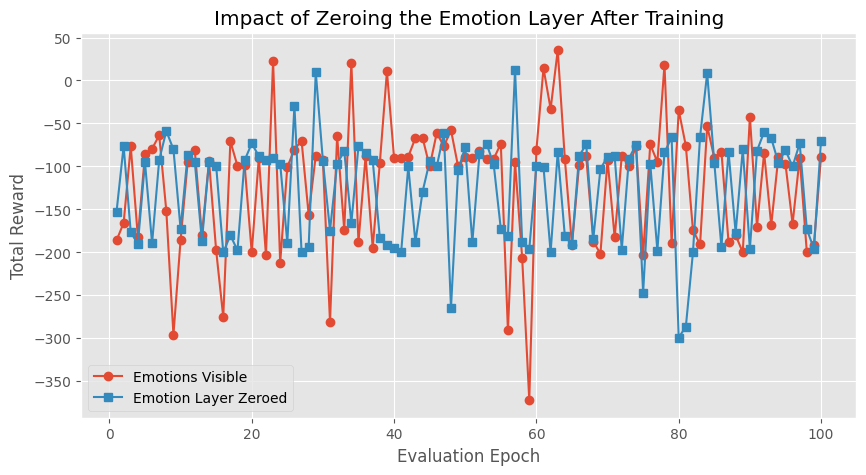

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['with_emotions'], label='Emotions Visible', marker='o')
plt.plot(df['epoch'], df['zeroed_emotions'], label='Emotion Layer Zeroed', marker='s')
plt.xlabel('Evaluation Epoch')
plt.ylabel('Total Reward')
plt.title('Impact of Zeroing the Emotion Layer After Training')
plt.legend()
plt.show()